# Performance penalty by using fewer taps

In [ ]:
%pip install --upgrade https://github.com/remifan/commplax/archive/master.zip
%pip install --upgrade https://github.com/remifan/LabPtPTm2/archive/master.zip
%pip install --upgrade https://github.com/remifan/gdbp_study/archive/master.zip

In [1]:
import os
import numpy as np
import pandas as pd
from tqdm.auto import tqdm
from functools import partial
import matplotlib.pyplot as plt
from commplax import util
from gdbp import gdbp_base as gb, data as gdat, plot as gplt, aux

In [2]:
ds_train, ds_test = gdat.load(1, 0, 4, 2)[0], gdat.load(2, 0, 4, 1)[0]

loading data:   0%|          | 0/1 [00:00<?, ?it/s]

loading data:   0%|          | 0/1 [00:00<?, ?it/s]

In [3]:
aux.dl_trained_params() # download pre-trained parameters
loc_trained_params = './trained_params/pretrained'

100% [..........................................................................] 1582928 / 1582928

In [ ]:
# use Pandas.Dataframe to store the results
df_test_res = pd.DataFrame({c: pd.Series(dtype=t) for c, t in {'ntaps': 'int',
                                                               'dtaps': 'int',
                                                               'xi': 'float',
                                                               'Model': 'str',
                                                               'Q': 'float'}.items()})

In [29]:
def init_models(data, hparams, mode='train'):
  model_conf = {'mode':  mode,
                'dtaps': hparams['dtaps'],
                'ntaps': hparams['ntaps'],
                'init_fn': gb.fdbp_init(data.a, steps=3, xi=hparams['xi'])}
  model_init = partial(gb.model_init, data, model_conf)
  fdbp = model_init([('fdbp_0',)]            , name='FDBP')
  edbp = model_init([('fdbp_0', r'DConv_\d')], name='EDBP')
  gdbp = model_init([],                        name='GDBP')
  return fdbp, edbp, gdbp


def sweep_hparams(hparams, df_test_res=df_test_res, use_pretrained_params=False, save_params=False):
  for i, hp in enumerate(tqdm(hparams, desc='sweeping hparams')):  # iterate hparams
    models_train = init_models(ds_train, hp)
    models_test = init_models(ds_test, hp, mode='test')
    
    for j, (model_train, model_test) in enumerate(tqdm(zip(models_train, models_test),
                                                       total=len(models_train),
                                                       desc='iterating models',
                                                       leave=False)):  # iterate models
      params_file = os.path.join(loc_trained_params,
                                 'snr_vs_dtaps_ntaps',
                                 'params_%d_%d' % (i, j)) # params_{hparam}_{model}
      
      if use_pretrained_params:
        params = util.load_variable(params_file)
      else:
        params_queue = [None] * 3
        
        for _, p, _ in gb.train(model_train, ds_train, n_iter=2000):
          params_queue.append(p)
          params = params_queue.pop(0)
        
        if save_params:
          util.save_variable(params, params_file)
        
      test_Q = gb.test(model_test, params, ds_test)[0].QSq.total
      # collect result
      df_test_res = df_test_res.append({'dtaps': hp['dtaps'],
                                        'ntaps': hp['ntaps'],
                                        'xi': hp['xi'],
                                        'Model': model_test.name,
                                        'Q': test_Q},
                                       ignore_index=True)
    
    if i % 10 == 0:
      util.clear_xla_cache() # clear compile cache periodically to save RAM

  return df_test_res

In [30]:
# make sweeping grid

# caveats: taps must be odd number
NTAPS = np.arange(1, 41, 6)
DTAPS = np.arange(181, 261, 12)
OPTXI = pd.read_csv('../../source_data/fdbp_opt_xi_ntaps.csv').values[:, 0]  # read optimal xi given dtaps

hparams = []
for ntaps, xi in zip(NTAPS, OPTXI):
  for dtaps in DTAPS:
    hparams.append({'ntaps': ntaps, 'dtaps': dtaps, 'xi': xi})

In [31]:
# it may take a while to finish
df_test_res = sweep_hparams(hparams, df_test_res, use_pretrained_params=True, save_params=False)
df_test_res

sweeping hparams:   0%|          | 0/49 [00:00<?, ?it/s]

iterating models:   0%|          | 0/3 [00:00<?, ?it/s]

iterating models:   0%|          | 0/3 [00:00<?, ?it/s]

iterating models:   0%|          | 0/3 [00:00<?, ?it/s]

iterating models:   0%|          | 0/3 [00:00<?, ?it/s]

iterating models:   0%|          | 0/3 [00:00<?, ?it/s]

iterating models:   0%|          | 0/3 [00:00<?, ?it/s]

iterating models:   0%|          | 0/3 [00:00<?, ?it/s]

iterating models:   0%|          | 0/3 [00:00<?, ?it/s]

iterating models:   0%|          | 0/3 [00:00<?, ?it/s]

iterating models:   0%|          | 0/3 [00:00<?, ?it/s]

iterating models:   0%|          | 0/3 [00:00<?, ?it/s]

iterating models:   0%|          | 0/3 [00:00<?, ?it/s]

iterating models:   0%|          | 0/3 [00:00<?, ?it/s]

iterating models:   0%|          | 0/3 [00:00<?, ?it/s]

iterating models:   0%|          | 0/3 [00:00<?, ?it/s]

iterating models:   0%|          | 0/3 [00:00<?, ?it/s]

iterating models:   0%|          | 0/3 [00:00<?, ?it/s]

iterating models:   0%|          | 0/3 [00:00<?, ?it/s]

iterating models:   0%|          | 0/3 [00:00<?, ?it/s]

iterating models:   0%|          | 0/3 [00:00<?, ?it/s]

iterating models:   0%|          | 0/3 [00:00<?, ?it/s]

iterating models:   0%|          | 0/3 [00:00<?, ?it/s]

iterating models:   0%|          | 0/3 [00:00<?, ?it/s]

iterating models:   0%|          | 0/3 [00:00<?, ?it/s]

iterating models:   0%|          | 0/3 [00:00<?, ?it/s]

iterating models:   0%|          | 0/3 [00:00<?, ?it/s]

iterating models:   0%|          | 0/3 [00:00<?, ?it/s]

iterating models:   0%|          | 0/3 [00:00<?, ?it/s]

iterating models:   0%|          | 0/3 [00:00<?, ?it/s]

iterating models:   0%|          | 0/3 [00:00<?, ?it/s]

iterating models:   0%|          | 0/3 [00:00<?, ?it/s]

iterating models:   0%|          | 0/3 [00:00<?, ?it/s]

iterating models:   0%|          | 0/3 [00:00<?, ?it/s]

iterating models:   0%|          | 0/3 [00:00<?, ?it/s]

iterating models:   0%|          | 0/3 [00:00<?, ?it/s]

iterating models:   0%|          | 0/3 [00:00<?, ?it/s]

iterating models:   0%|          | 0/3 [00:00<?, ?it/s]

iterating models:   0%|          | 0/3 [00:00<?, ?it/s]

iterating models:   0%|          | 0/3 [00:00<?, ?it/s]

iterating models:   0%|          | 0/3 [00:00<?, ?it/s]

iterating models:   0%|          | 0/3 [00:00<?, ?it/s]

iterating models:   0%|          | 0/3 [00:00<?, ?it/s]

iterating models:   0%|          | 0/3 [00:00<?, ?it/s]

iterating models:   0%|          | 0/3 [00:00<?, ?it/s]

iterating models:   0%|          | 0/3 [00:00<?, ?it/s]

iterating models:   0%|          | 0/3 [00:00<?, ?it/s]

iterating models:   0%|          | 0/3 [00:00<?, ?it/s]

iterating models:   0%|          | 0/3 [00:00<?, ?it/s]

iterating models:   0%|          | 0/3 [00:00<?, ?it/s]

,ntaps,dtaps,xi,Model,Q
0,1,181,0.15,FDBP,7.239062
1,1,181,0.15,EDBP,7.244903
2,1,181,0.15,GDBP,8.223946
3,1,193,0.15,FDBP,7.611000
4,1,193,0.15,EDBP,7.618716
...,...,...,...,...,...
142,37,241,1.10,EDBP,8.596812
143,37,241,1.10,GDBP,8.741637
144,37,253,1.10,FDBP,8.590569
145,37,253,1.10,EDBP,8.670206


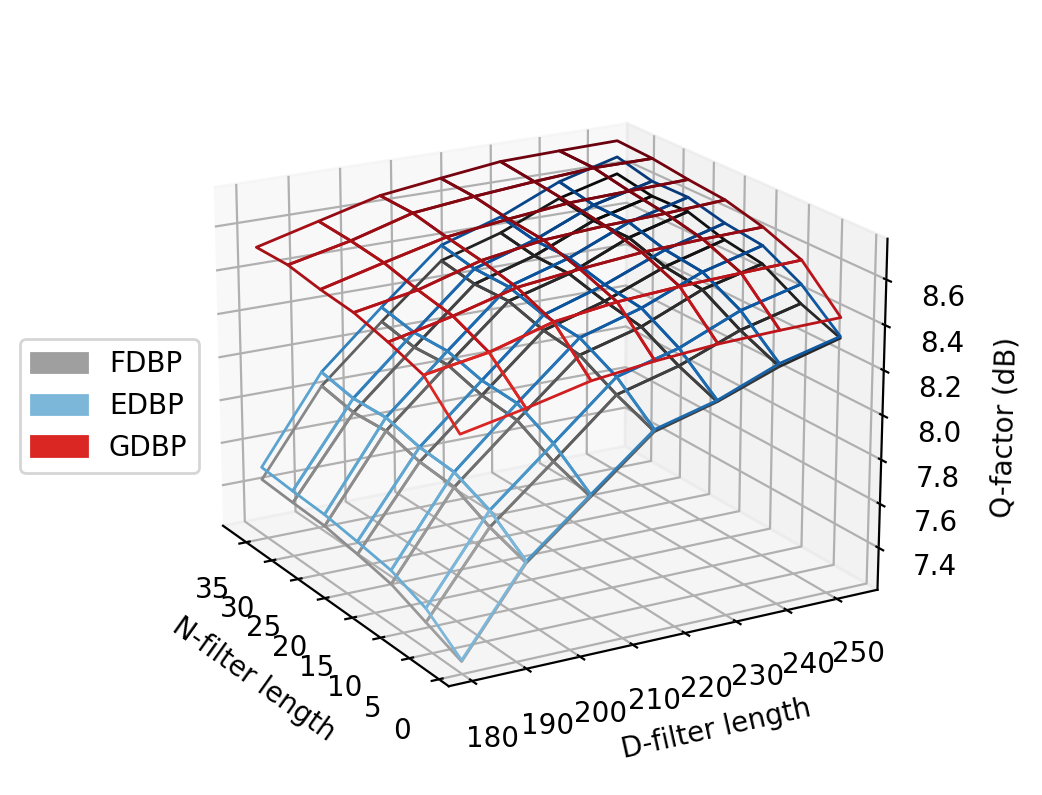

In [100]:
fig, ax = plt.subplots(subplot_kw={"projection": "3d"}, figsize=(5, 5), dpi=200)
ax.view_init(19, -30)
curves = 20
cms = [plt.cm.Greys, plt.cm.Blues, plt.cm.Reds]

colors = plt.cm.RdPu_r(np.linspace(0., 0.5, 3))[::-1]

for cm, mod in zip(cms, ['FDBP', 'EDBP', 'GDBP']):
  df = df_test_res.groupby('Model').get_group(mod).pivot('dtaps', 'ntaps', 'Q')
  (X, Y), Z = np.meshgrid(df.columns.values, df.index.values), df.values
  gplt.wireframe_cmap(ax, X, Y, Z, cmap=cm, offset=[-1.2, 0], label=mod)
  
ax.set_xlabel('N-filter length')
ax.set_ylabel('D-filter length')
ax.set_zlabel('Q-factor (dB)')
ax.invert_xaxis()
ax.legend(loc=(-0.18, 0.4))